- `tensorflow 2.4.0` 에서 `WARNING:tensorflow:Your input ran out of data;`의 에러가 발생함 
  - keras, tensorflow downgrade 로 해결

In [1]:
!pip uninstall keras
!pip unintsall tensorflow

!pip install keras==2.3.1
!pip install tensorflow==2.2.0

Uninstalling Keras-2.4.3:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.4.3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.4.3
ERROR: unknown command "unintsall" - maybe you meant "uninstall"
     |████████████████████████████████| 378kB 8.1MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 516.2MB 28kB/s 
     |████████████████████████████████| 3.0MB 57.3MB/s 
     |████████████████████████████████| 460kB 49.3MB/s 
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-e

In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


## Import Libraries

In [3]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Activation, Dropout, Lambda, Flatten
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Convolution2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os

Using TensorFlow backend.


# Read Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/Kaggle/Digit Recognizer/input')

Mounted at /content/drive


In [5]:
from subprocess import check_output
print(check_output(['ls', '../input']).decode('utf8'))

01_submission.csv
submission1.csv
submission2.csv
submission.csv
test.csv
train.csv



# Train/Test

In [6]:
train = pd.read_csv("../input/train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
test = pd.read_csv("../input/test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
X_train = (train.iloc[:, 1:].values).astype('float32') 
y_train = train.iloc[:, 0].values.astype('int32') # target
X_test = test.values.astype('float32')

In [9]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
y_train

array([1, 0, 1, ..., 7, 6, 9], dtype=int32)

# Data Visualization

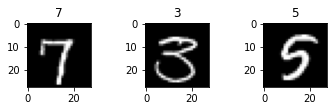

In [11]:
# (num_images, img_rows, img_cols) format
X_train = X_train.reshape(X_train.shape[0], 28, 28)

for i in range(6, 9):
  plt.subplot(330 + (i+1))
  plt.imshow(X_train[i], cmap = plt.get_cmap('gray'))
  plt.title(y_train[i])

- expand 1 more dimension as 1 for colour channel gray

In [12]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_train.shape

(42000, 28, 28, 1)

In [13]:
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_test.shape

(28000, 28, 28, 1)

# **Preprocessing the digit images**

## *Feature Standardization*

In [14]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

def standardize(x):
  return (x-mean_px)/std_px

## *One Hot Encoding*

In [15]:
y_train = np_utils.to_categorical(y_train) # to_categorical
num_classes = y_train.shape[1]
print(num_classes)

10


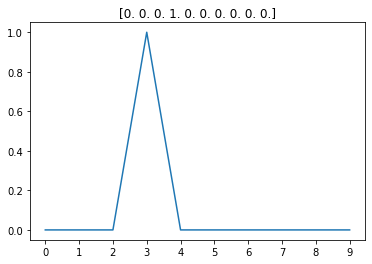

In [16]:
plt.title(y_train[9])
plt.plot(y_train[9])
plt.xticks(range(10));

In [17]:
from keras.preprocessing import image
gen = image.ImageDataGenerator()

In [18]:
from sklearn.model_selection import train_test_split
X = X_train
y = y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches=gen.flow(X_val, y_val, batch_size=64)

In [32]:
from keras.layers import Convolution2D, MaxPooling2D

def get_cnn_model():
  model = Sequential([
      Lambda(standardize, input_shape = (28, 28, 1)),
      Convolution2D(32, (3, 3), activation = tf.keras.activations.swish),
      BatchNormalization(axis=1), 
      Convolution2D(32, (3, 3), activation = tf.keras.activations.swish),
      MaxPooling2D(),
      Convolution2D(64, (3, 3), activation = tf.keras.activations.swish),
      BatchNormalization(axis=1),
      Convolution2D(64, (3, 3), activation = tf.keras.activations.swish),
      MaxPooling2D(),
      Flatten(),
      BatchNormalization(axis=1),
      Dense(512, activation = tf.keras.activations.swish),
      BatchNormalization(axis=1),
      Dense(10, activation = 'softmax')
  ])
  model.compile(optimizer = Adam(lr = 0.002),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
  return model

- 아래 코드로 오류 해결

In [33]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.2.0
tf.keras.__version__ is: 2.3.0-tf


In [34]:
model = get_cnn_model()

In [35]:
history = model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3, 
                              validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/3
37800/37800 [==============================] - 366s 10ms/step - loss: 0.0092 - accuracy: 0.9972 - val_loss: 0.0465 - val_accuracy: 0.9929
Epoch 2/3
37800/37800 [==============================] - 369s 10ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 1.6764e-08 - val_accuracy: 0.9919
Epoch 3/3
37800/37800 [==============================] - 372s 10ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 3.8184e-07 - val_accuracy: 0.9945


In [40]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

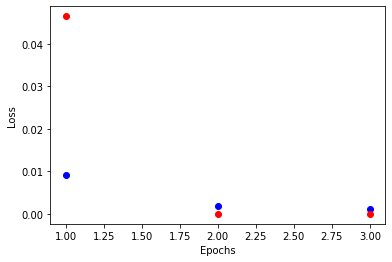

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss_values, 'bo')
# b+ is for "blue crosses"
plt.plot(epochs, val_loss_values, 'ro')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [36]:
print("Generating test predictions...")
preds = model.predict_classes(X_test, verbose = 0)

Generating test predictions...


In [37]:
def write_preds(preds, fname):
  pd.DataFrame({'ImageId': list(range(1, len(preds) + 1)), 'Label': preds}).to_csv(fname, index = False, header = True)

write_preds(preds, 'submission1.csv')